In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

data = fetch_covtype()
X = data.data
y = data.target

encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Входной слой и первый скрытый слой
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))  # Dropout для предотвращения переобучения

# Второй скрытый слой
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))

# Выходной слой (7 классов)
model.add(Dense(units=7, activation='softmax'))  # softmax для многоклассовой классификации

model.compile(loss='sparse_categorical_crossentropy',  # для многоклассовой классификации
              optimizer=Adam(), 
              metrics=['accuracy'])

model.summary()


2024-11-10 20:53:45.031073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 20:53:45.061056: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 20:53:45.108458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731261225.145439   43298 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731261225.158637   43298 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 20:53:45.259286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,751 (61.53 KB)

 Trainable params: 15,751 (61.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7103 - loss: 0.6899 - val_accuracy: 0.7785 - val_loss: 0.5117
Epoch 2/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7696 - loss: 0.5362 - val_accuracy: 0.8006 - val_loss: 0.4692
Epoch 3/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7862 - loss: 0.4993 - val_accuracy: 0.8150 - val_loss: 0.4388
Epoch 4/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7935 - loss: 0.4798 - val_accuracy: 0.8249 - val_loss: 0.4178
Epoch 5/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8011 - loss: 0.4657 - val_accuracy: 0.8289 - val_loss: 0.4050
Epoch 6/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8053 - loss: 0.4554 - val_accuracy: 0.8332 - val_loss: 0.3959
Epoch 7/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8085 - loss: 0.4478 - val_accuracy: 0.8387 - val_loss: 0.3866
Epoch 8/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8118 - loss: 0.4410 

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(f"Accuracy: {accuracy_score(y_test, y_pred_classes):.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


5447/5447 ━━━━━━━━━━━━━━━━━━━━ 3s 598us/step
Accuracy: 0.8621
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86     63556
           1       0.86      0.91      0.89     85078
           2       0.84      0.84      0.84     10638
           3       0.78      0.66      0.72       795
           4       0.82      0.42      0.56      2941
           5       0.68      0.71      0.69      5227
           6       0.87      0.87      0.87      6069

    accuracy                           0.86    174304
   macro avg       0.82      0.75      0.77    174304
weighted avg       0.86      0.86      0.86    174304



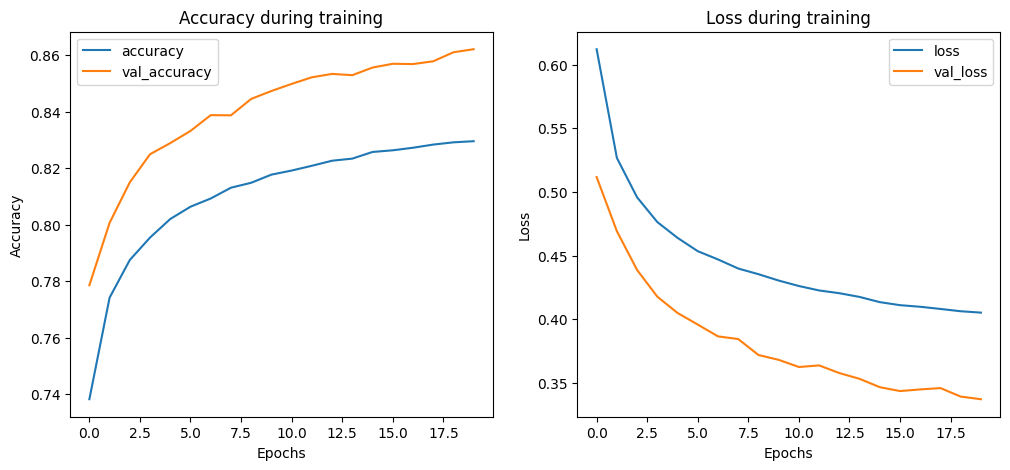

In [ ]:
# Визуализация истории обучения
plt.figure(figsize=(12, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Модифицированная модель
model = Sequential()

# Входной слой и скрытые слои с другими гиперпараметрами
model.add(Dense(units=256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))  # Увеличиваем dropout

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),  # Изменение скорости обучения
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


/home/dbulgakov/ml/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7164 - loss: 0.6713 - val_accuracy: 0.7904 - val_loss: 0.4883
Epoch 2/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7794 - loss: 0.5145 - val_accuracy: 0.8156 - val_loss: 0.4392
Epoch 3/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7965 - loss: 0.4764 - val_accuracy: 0.8278 - val_loss: 0.4075
Epoch 4/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8064 - loss: 0.4542 - val_accuracy: 0.8386 - val_loss: 0.3896
Epoch 5/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8124 - loss: 0.4404 - val_accuracy: 0.8450 - val_loss: 0.3726
Epoch 6/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8184 - loss: 0.4266 - val_accuracy: 0.8516 - val_loss: 0.3604
Epoch 7/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8228 - loss: 0.4161 - val_accuracy: 0.8559 - val_loss: 0.3505
Epoch 8/20
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8247 - loss: 0

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(f"Accuracy: {accuracy_score(y_test, y_pred_classes):.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

5447/5447 ━━━━━━━━━━━━━━━━━━━━ 4s 655us/step
Accuracy: 0.8797
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     63556
           1       0.87      0.94      0.90     85078
           2       0.85      0.87      0.86     10638
           3       0.76      0.73      0.74       795
           4       0.85      0.44      0.58      2941
           5       0.75      0.74      0.74      5227
           6       0.90      0.89      0.89      6069

    accuracy                           0.88    174304
   macro avg       0.84      0.78      0.80    174304
weighted avg       0.88      0.88      0.88    174304



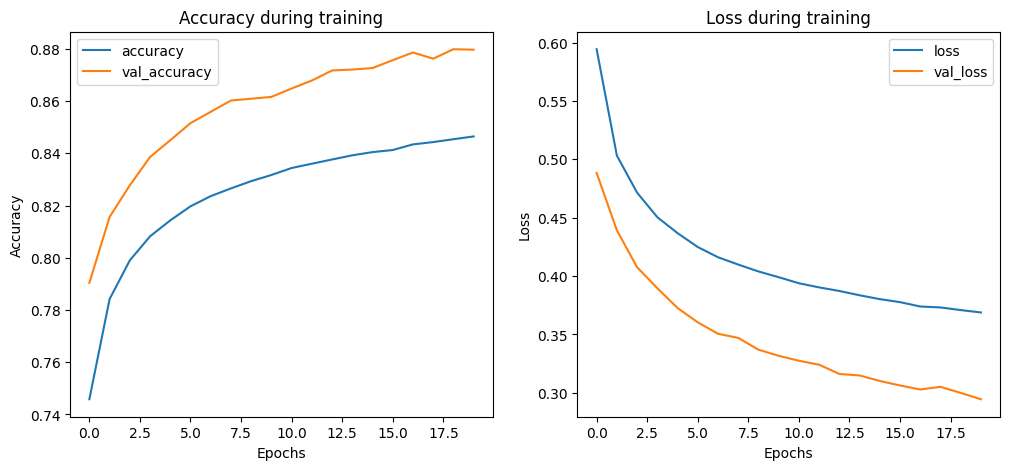

In [ ]:
# Визуализация истории обучения
plt.figure(figsize=(12, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()